In [1]:
# Add the Model Scripts folder to the path
import sys
sys.path.append("Scripts")
sys.path.append("Weights")


# Import the necessary libraries
import torch
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Import the function to create the model
from Scripts.ArithmeticTransformer import create_arithmetic_transformer

# Create a model with default parameters
model = create_arithmetic_transformer()

# Or create a model with custom parameters
model = create_arithmetic_transformer(
    vocab_size=14,
    embed_size=128,
    num_heads=4,
    ff_dim=512,
    num_layers=3,
    max_length=64
)

In [10]:
import torch

def load_model(model_path, device=None):
    # Determine device
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load checkpoint
    print(f"Loading model on {device}")
    checkpoint = torch.load(model_path, map_location=device)
    
    # Extract config
    config = checkpoint['model_config']
    print("Model configuration:", config)
    
    # Create model
    model = create_arithmetic_transformer(
        vocab_size=config['vocab_size'],
        embed_size=config['embed_size'],
        num_heads=config['num_heads'],
        ff_dim=config['ff_dim'],
        num_layers=config['num_layers'],
        max_length=config['max_length'],
        dropout=config['dropout']
    )
    
    # Load state dict
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Move model to device and set to eval mode
    model = model.to(device)
    model.eval()
    
    # Get vocab if available
    vocab = checkpoint.get('vocab')
    inv_vocab = checkpoint.get('inv_vocab')
    
    print(f"Model loaded successfully! Best accuracy: {checkpoint['accuracy']:.4f}")
    
    return model, vocab, inv_vocab, device, config

# Usage:
model_path = './Weights/large_addition_model.pth'
model, vocab, inv_vocab, device, config = load_model(model_path)

Loading model on cpu
Model configuration: {'vocab_size': 14, 'embed_size': 512, 'num_heads': 8, 'ff_dim': 2048, 'num_layers': 8, 'max_length': 42, 'dropout': 0.15}
Model loaded successfully! Best accuracy: 1.0000


In [38]:
# If you need to use the model for inference, you'll want these helper functions:
def preprocess_input(input_str, max_length, vocab):
    # Reverse the input string
    input_str = input_str[::-1]
    # Tokenize
    tokens = [vocab[c] for c in input_str if c in vocab]
    # Pad
    padded = tokens + [vocab['<PAD>']] * (max_length - len(tokens))
    return torch.tensor(padded).unsqueeze(0)  # Add batch dimension

def decode_output(output_tensor, inv_vocab):
    _, predicted = output_tensor.max(2)
    decoded = []
    for token in predicted[0]:
        token_val = token.item()
        if token_val == vocab['<EOS>']:
            break
        if token_val != vocab['<PAD>']:
            decoded.append(inv_vocab[token_val])
    return ''.join(decoded)[::-1]  # Reverse at the end

# Example usage:
def test_addition(num1, num2, model, vocab, inv_vocab, max_length):
    input_str = f"{num1}+{num2}="
    input_tensor = preprocess_input(input_str, max_length, vocab)
    with torch.no_grad():
        output = model(input_tensor)
        result = decode_output(output, inv_vocab)
    print(f"{num1} + {num2} = {result}")
    print(f"Correct result: {num1 + num2}")
    print(f"Model's prediction is {'correct' if int(result) == num1 + num2 else 'incorrect'}")

In [39]:
# Test a simple addition
test_addition(123, 456, model, vocab, inv_vocab, config['max_length'])

# or test multiple additions in a loop
test_cases = [
    (5, 7),
    (42, 58),
    (123, 456),
    (1234, 5678)
]

for num1, num2 in test_cases:
    test_addition(num1, num2, model, vocab, inv_vocab, config['max_length'])

123 + 456 = 579
Correct result: 579
Model's prediction is correct
5 + 7 = 12
Correct result: 12
Model's prediction is correct
42 + 58 = 100
Correct result: 100
Model's prediction is correct
123 + 456 = 579
Correct result: 579
Model's prediction is correct
1234 + 5678 = 6912
Correct result: 6912
Model's prediction is correct


In [40]:
  # Test a simple addition
test_addition(123, 456, model, vocab, inv_vocab, config['max_length'])

# or test multiple additions in a loop
test_cases = [
    (5, 7),
    (42, 58),
    (123, 456),
    (1234, 5678),
    (10304923, 123123123),
    (123123123, 10304923)

]

for num1, num2 in test_cases:
    test_addition(num1, num2, model, vocab, inv_vocab, config['max_length'])

123 + 456 = 579
Correct result: 579
Model's prediction is correct
5 + 7 = 12
Correct result: 12
Model's prediction is correct
42 + 58 = 100
Correct result: 100
Model's prediction is correct
123 + 456 = 579
Correct result: 579
Model's prediction is correct
1234 + 5678 = 6912
Correct result: 6912
Model's prediction is correct
10304923 + 123123123 = 133428046
Correct result: 133428046
Model's prediction is correct
123123123 + 10304923 = 133428046
Correct result: 133428046
Model's prediction is correct


In [41]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import random

class ArithmeticModelTester:
    def __init__(self, model, vocab, inv_vocab, max_seq_length):
        self.model = model
        self.vocab = vocab
        self.inv_vocab = inv_vocab
        self.max_seq_length = max_seq_length
        self.model.eval()
        self.results = defaultdict(dict)
        
    def preprocess_input(self, input_str):
        """Preprocess input string for model"""
        input_str = input_str[::-1]  # Reverse string
        tokens = [self.vocab[c] for c in input_str if c in self.vocab]
        padded = tokens + [self.vocab['<PAD>']] * (self.max_seq_length - len(tokens))
        return torch.tensor(padded).unsqueeze(0)
    
    def decode_output(self, output_tensor):
        """Decode model output"""
        _, predicted = output_tensor.max(2)
        decoded = []
        for token in predicted[0]:
            token_val = token.item()
            if token_val == self.vocab['<EOS>']:
                break
            if token_val != self.vocab['<PAD>']:
                decoded.append(self.inv_vocab[token_val])
        return ''.join(decoded)[::-1]

    def test_single_digits(self, num_trials=100):
        """Test single digit additions"""
        correct = 0
        for _ in range(num_trials):
            n1 = random.randint(0, 9)
            n2 = random.randint(0, 9)
            result = self.predict_addition(n1, n2)
            if result == n1 + n2:
                correct += 1
        self.results['single_digits'] = {'accuracy': correct/num_trials}
        return correct/num_trials

    def test_commutative_property(self, max_digit=999, num_trials=100):
        """Test if a + b == b + a"""
        correct = 0
        for _ in range(num_trials):
            n1 = random.randint(0, max_digit)
            n2 = random.randint(0, max_digit)
            result1 = self.predict_addition(n1, n2)
            result2 = self.predict_addition(n2, n1)
            if result1 == result2 == (n1 + n2):
                correct += 1
        self.results['commutative'] = {'accuracy': correct/num_trials}
        return correct/num_trials

    def test_zero_property(self, max_digit=999, num_trials=100):
        """Test additions with zero"""
        correct = 0
        for _ in range(num_trials):
            n = random.randint(0, max_digit)
            result1 = self.predict_addition(n, 0)
            result2 = self.predict_addition(0, n)
            if result1 == result2 == n:
                correct += 1
        self.results['zero_property'] = {'accuracy': correct/num_trials}
        return correct/num_trials

    def test_by_length(self, max_length=5):
        """Test additions with different number lengths"""
        results = {}
        for length in range(1, max_length + 1):
            correct = 0
            trials = 100
            for _ in range(trials):
                n1 = random.randint(10**(length-1), 10**length - 1)
                n2 = random.randint(10**(length-1), 10**length - 1)
                result = self.predict_addition(n1, n2)
                if result == n1 + n2:
                    correct += 1
            results[length] = correct/trials
        self.results['length_wise'] = results
        return results

    def test_carries(self):
        """Test additions requiring different numbers of carries"""
        test_cases = [
            (9, 1),      # Single carry
            (99, 1),     # Double carry
            (999, 1),    # Triple carry
            (19, 81),    # Multiple carries
            (999999, 1)  # Many carries
        ]
        results = {}
        for n1, n2 in test_cases:
            result = self.predict_addition(n1, n2)
            results[f"{n1}+{n2}"] = result == n1 + n2
        self.results['carries'] = results
        return results

    def predict_addition(self, n1, n2):
        """Make a prediction for n1 + n2"""
        input_str = f"{n1}+{n2}="
        input_tensor = self.preprocess_input(input_str)
        with torch.no_grad():
            output = self.model(input_tensor)
            result_str = self.decode_output(output)
            try:
                return int(result_str)
            except ValueError:
                return None

    def visualize_results(self):
        """Visualize test results"""
        plt.figure(figsize=(15, 10))
        
        # Plot accuracy by number length
        if 'length_wise' in self.results:
            plt.subplot(2, 2, 1)
            lengths = list(self.results['length_wise'].keys())
            accuracies = list(self.results['length_wise'].values())
            plt.plot(lengths, accuracies, marker='o')
            plt.title('Accuracy by Number Length')
            plt.xlabel('Number Length (digits)')
            plt.ylabel('Accuracy')

        # Plot bar chart of different properties
        properties = ['single_digits', 'commutative', 'zero_property']
        accuracies = [self.results[prop]['accuracy'] for prop in properties if prop in self.results]
        if accuracies:
            plt.subplot(2, 2, 2)
            plt.bar(properties, accuracies)
            plt.title('Accuracy by Property')
            plt.xticks(rotation=45)
            plt.ylabel('Accuracy')

        plt.tight_layout()
        plt.show()

# Example usage:
"""
# Load your model and necessary components
model = load_model('path_to_model.pth')
vocab = {...}  # Your vocabulary
inv_vocab = {...}  # Inverse vocabulary
max_seq_length = 42  # Your max sequence length

# Create tester instance
tester = ArithmeticModelTester(model, vocab, inv_vocab, max_seq_length)

# Run tests
tester.test_single_digits()
tester.test_commutative_property()
tester.test_zero_property()
tester.test_by_length()
tester.test_carries()

# Visualize results
tester.visualize_results()
"""

"\n# Load your model and necessary components\nmodel = load_model('path_to_model.pth')\nvocab = {...}  # Your vocabulary\ninv_vocab = {...}  # Inverse vocabulary\nmax_seq_length = 42  # Your max sequence length\n\n# Create tester instance\ntester = ArithmeticModelTester(model, vocab, inv_vocab, max_seq_length)\n\n# Run tests\ntester.test_single_digits()\ntester.test_commutative_property()\ntester.test_zero_property()\ntester.test_by_length()\ntester.test_carries()\n\n# Visualize results\ntester.visualize_results()\n"

In [4]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import pandas as pd
from datetime import datetime

class ModelEvaluator:
    def __init__(self, model, vocab, inv_vocab, max_seq_length, random_seed=42):
        """
        Initialize evaluator with model and set random seed for reproducibility
        """
        self.model = model
        self.vocab = vocab
        self.inv_vocab = inv_vocab
        self.max_seq_length = max_seq_length
        self.model.eval()
        
        # Set random seeds for reproducibility
        torch.manual_seed(random_seed)
        np.random.seed(random_seed)
        random.seed(random_seed)
        
        # Store test configuration
        self.test_config = {
            'random_seed': random_seed,
            'timestamp': datetime.now().strftime('%Y-%m-%d_%H-%M-%S'),
            'max_seq_length': max_seq_length
        }
        
    def generate_test_case(self, min_digits=1, max_digits=20):
        """Generate a random test case with specified digit length range"""
        len1 = random.randint(min_digits, max_digits)
        len2 = random.randint(min_digits, max_digits)
        
        num1 = random.randint(10**(len1-1), 10**len1 - 1)
        num2 = random.randint(10**(len2-1), 10**len2 - 1)
        
        return num1, num2, len1, len2

    def preprocess_input(self, input_str):
        """Preprocess input string for model"""
        input_str = input_str[::-1]  # Reverse string
        tokens = [self.vocab[c] for c in input_str if c in self.vocab]
        padded = tokens + [self.vocab['<PAD>']] * (self.max_seq_length - len(tokens))
        return torch.tensor(padded).unsqueeze(0)
    
    def decode_output(self, output_tensor):
        """Decode model output"""
        _, predicted = output_tensor.max(2)
        decoded = []
        for token in predicted[0]:
            token_val = token.item()
            if token_val == self.vocab['<EOS>']:
                break
            if token_val != self.vocab['<PAD>']:
                decoded.append(self.inv_vocab[token_val])
        return ''.join(decoded)[::-1]

    def evaluate_model(self, num_samples=10000):
        """
        Evaluate model on random test cases and collect detailed metrics
        """
        results = []
        
        for _ in tqdm(range(num_samples), desc="Evaluating Model"):
            # Generate test case
            num1, num2, len1, len2 = self.generate_test_case()
            true_result = num1 + num2
            
            # Get model prediction
            input_str = f"{num1}+{num2}="
            input_tensor = self.preprocess_input(input_str)
            
            with torch.no_grad():
                output = self.model(input_tensor)
                pred_str = self.decode_output(output)
                
            try:
                pred_result = int(pred_str)
                is_correct = pred_result == true_result
            except ValueError:
                pred_result = None
                is_correct = False
            
            # Collect detailed information about this test case
            results.append({
                'num1': num1,
                'num2': num2,
                'len1': len1,
                'len2': len2,
                'max_len': max(len1, len2),
                'total_len': len1 + len2,
                'true_result': true_result,
                'predicted_result': pred_result,
                'is_correct': is_correct,
                'carries': self.count_carries(num1, num2)
            })
        
        return pd.DataFrame(results)

    def count_carries(self, num1, num2):
        """Count the number of carry operations in addition"""
        carry = 0
        carries = 0
        
        while num1 > 0 or num2 > 0 or carry:
            digit1 = num1 % 10
            digit2 = num2 % 10
            
            if digit1 + digit2 + carry >= 10:
                carries += 1
                carry = 1
            else:
                carry = 0
                
            num1 //= 10
            num2 //= 10
            
        return carries

    def analyze_results(self, df):
        """
        Analyze results and generate comprehensive metrics
        """
        metrics = {
            'test_config': self.test_config,
            'overall_accuracy': df['is_correct'].mean(),
            'total_samples': len(df),
            'metrics_by_length': {},
            'metrics_by_carries': {}
        }
        
        # Analyze by maximum length of operands
        for length in range(1, 21):
            length_df = df[df['max_len'] == length]
            if len(length_df) > 0:
                metrics['metrics_by_length'][length] = {
                    'accuracy': length_df['is_correct'].mean(),
                    'samples': len(length_df)
                }
        
        # Analyze by number of carries
        for carries in df['carries'].unique():
            carries_df = df[df['carries'] == carries]
            metrics['metrics_by_carries'][int(carries)] = {
                'accuracy': carries_df['is_correct'].mean(),
                'samples': len(carries_df)
            }
        
        return metrics

    def visualize_results(self, df, metrics):
        """
        Create visualizations of model performance
        """
        plt.figure(figsize=(20, 10))
        
        # Plot 1: Accuracy by maximum length
        plt.subplot(2, 2, 1)
        lengths = list(metrics['metrics_by_length'].keys())
        accuracies = [metrics['metrics_by_length'][l]['accuracy'] for l in lengths]
        plt.plot(lengths, accuracies, marker='o')
        plt.title('Accuracy by Maximum Length of Operands')
        plt.xlabel('Maximum Length (digits)')
        plt.ylabel('Accuracy')
        
        # Plot 2: Accuracy by number of carries
        plt.subplot(2, 2, 2)
        carries = list(metrics['metrics_by_carries'].keys())
        carry_accuracies = [metrics['metrics_by_carries'][c]['accuracy'] for c in carries]
        plt.plot(carries, carry_accuracies, marker='o', color='orange')
        plt.title('Accuracy by Number of Carries')
        plt.xlabel('Number of Carries')
        plt.ylabel('Accuracy')
        
        # Plot 3: Distribution of test cases
        plt.subplot(2, 2, 3)
        sns.histplot(data=df, x='max_len', bins=20)
        plt.title('Distribution of Test Cases by Maximum Length')
        plt.xlabel('Maximum Length (digits)')
        
        # Plot 4: Heatmap of length combinations
        plt.subplot(2, 2, 4)
        heatmap_data = pd.crosstab(df['len1'], df['len2'])
        sns.heatmap(heatmap_data, cmap='YlOrRd')
        plt.title('Distribution of Length Combinations')
        plt.xlabel('Length of Second Number')
        plt.ylabel('Length of First Number')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print("\nSummary Statistics:")
        print(f"Overall Accuracy: {metrics['overall_accuracy']:.4f}")
        print(f"Total Samples: {metrics['total_samples']}")

In [6]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import pandas as pd
from datetime import datetime

# Recreate the model architecture (you'll need to import your model class)
from Scripts.ArithmeticTransformer import *
    

# First, let's load the model correctly
def load_model_and_config(model_path):
    """Load the model and its configuration"""    
    # Load checkpoint
    print(f"Loading model on {device}")
    checkpoint = torch.load(model_path, map_location=device)
    
    # Extract config
    config = checkpoint['model_config']
    print("Model configuration:", config)
    
    # Create model
    model = create_arithmetic_transformer(
        vocab_size=config['vocab_size'],
        embed_size=config['embed_size'],
        num_heads=config['num_heads'],
        ff_dim=config['ff_dim'],
        num_layers=config['num_layers'],
        max_length=config['max_length'],
        dropout=config['dropout']
    )
    
    # Load state dict
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Move model to device and set to eval mode
    model = model.to(device)
    model.eval()
    
    # Get vocab if available
    vocab = checkpoint.get('vocab')
    inv_vocab = checkpoint.get('inv_vocab')
    
    print(f"Model loaded successfully! Best accuracy: {checkpoint['accuracy']:.4f}")
    
    return model, vocab, inv_vocab, config['max_length']
    
# [Previous ModelEvaluator class code remains the same]

Loading model on cpu
Model configuration: {'vocab_size': 14, 'embed_size': 64, 'num_heads': 2, 'ff_dim': 256, 'num_layers': 2, 'max_length': 42, 'dropout': 0.1}
Model loaded successfully! Best accuracy: 0.7937


Evaluating Model: 100%|██████████| 10000/10000 [00:23<00:00, 430.51it/s]


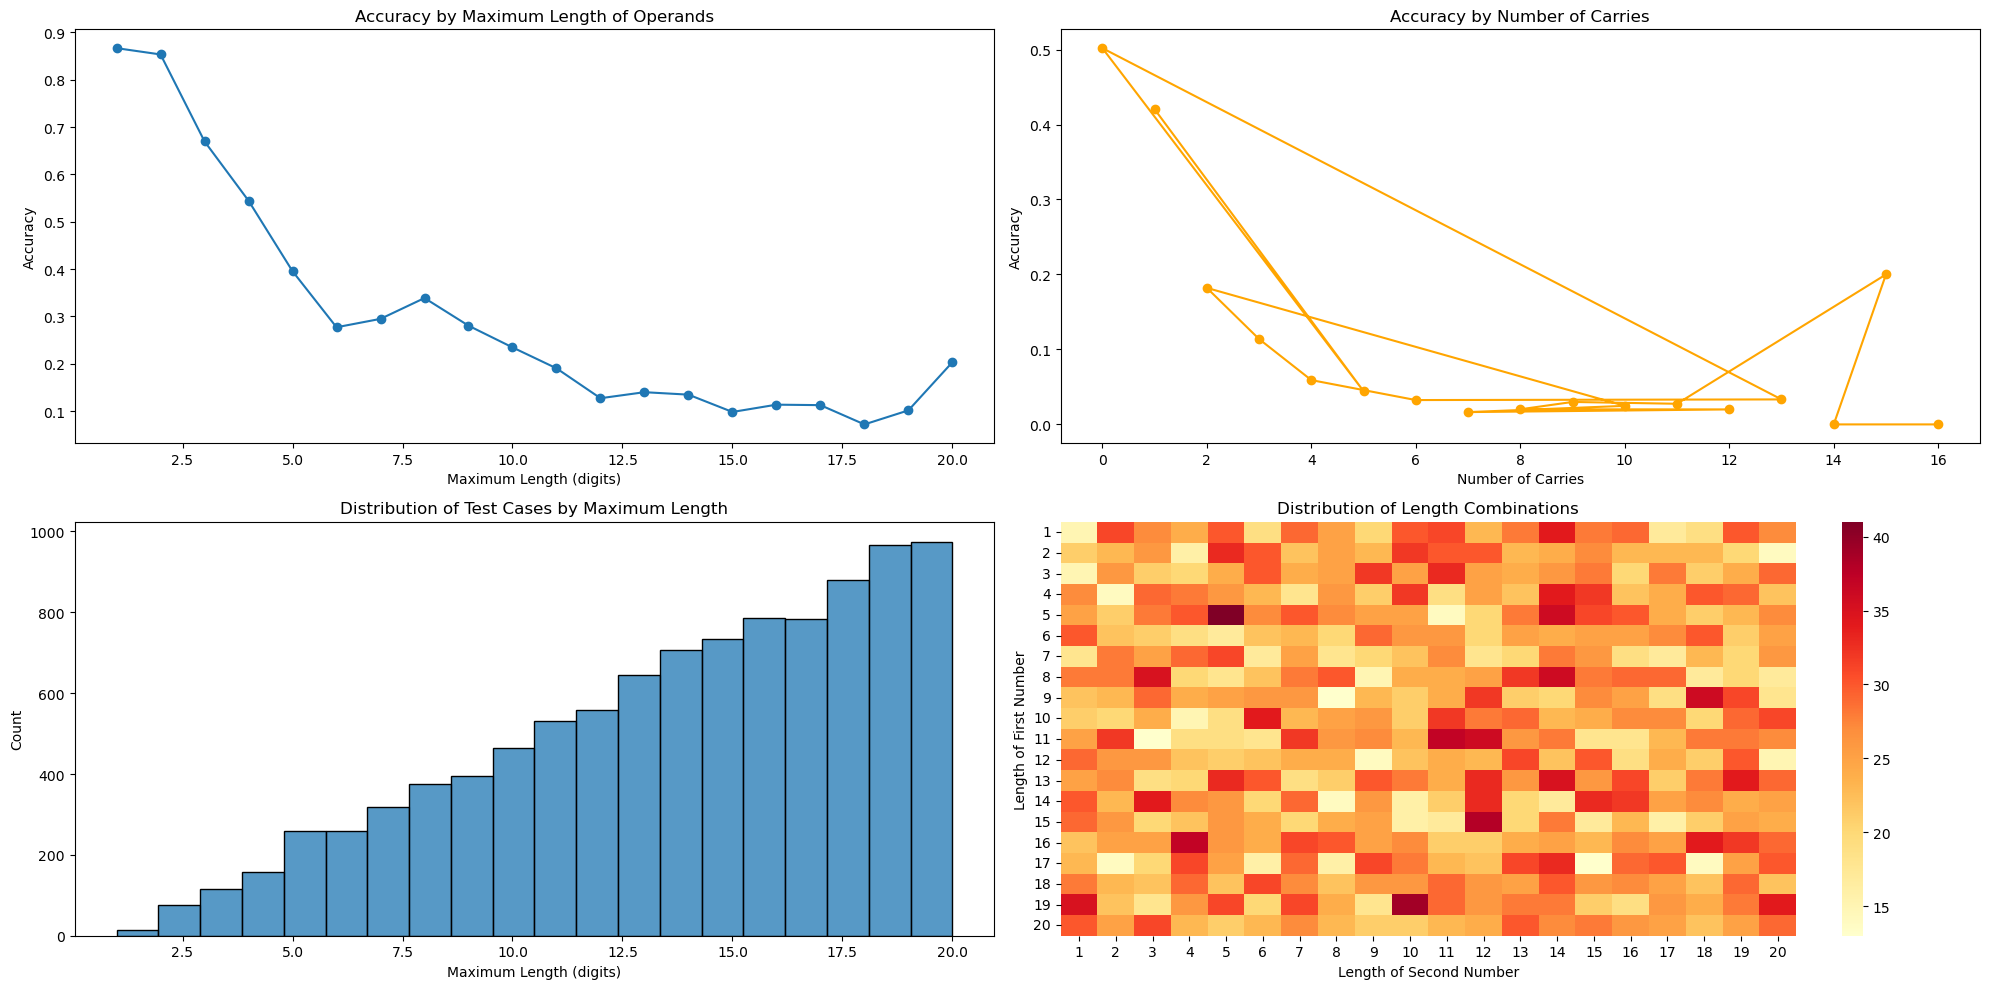


Summary Statistics:
Overall Accuracy: 0.1820
Total Samples: 10000

Detailed Statistics:
Number of correct predictions: 1820
Average number of carries: 3.65

Performance by length ranges:
1-5 digits: 0.5507
6-10 digits: 0.2826
11-15 digits: 0.1351
16-20 digits: 0.1221


In [15]:
# SMALL MODEL EVALUATION
# Load model and components
model_path = './Weights/small_addition_model.pth'  # Update with your model path
model, vocab, inv_vocab, max_seq_length = load_model_and_config(model_path)

# Create evaluator with specific random seed
evaluator = ModelEvaluator(model, vocab, inv_vocab, max_seq_length, random_seed=42)

# Run evaluation
results_df = evaluator.evaluate_model(num_samples=10000)
metrics = evaluator.analyze_results(results_df)

# Visualize results
evaluator.visualize_results(results_df, metrics)

# Save results
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
results_df.to_csv(f'model_evaluation_{timestamp}.csv')

# Print some interesting statistics
print("\nDetailed Statistics:")
print(f"Number of correct predictions: {results_df['is_correct'].sum()}")
print(f"Average number of carries: {results_df['carries'].mean():.2f}")

# Print performance by length ranges
print("\nPerformance by length ranges:")
length_ranges = [(1,5), (6,10), (11,15), (16,20)]
for start, end in length_ranges:
    mask = (results_df['max_len'] >= start) & (results_df['max_len'] <= end)
    acc = results_df[mask]['is_correct'].mean()
    print(f"{start}-{end} digits: {acc:.4f}")

Loading model on cpu
Model configuration: {'vocab_size': 14, 'embed_size': 256, 'num_heads': 4, 'ff_dim': 1024, 'num_layers': 4, 'max_length': 42, 'dropout': 0.1}
Model loaded successfully! Best accuracy: 0.9987


Evaluating Model: 100%|██████████| 10000/10000 [01:44<00:00, 96.03it/s]


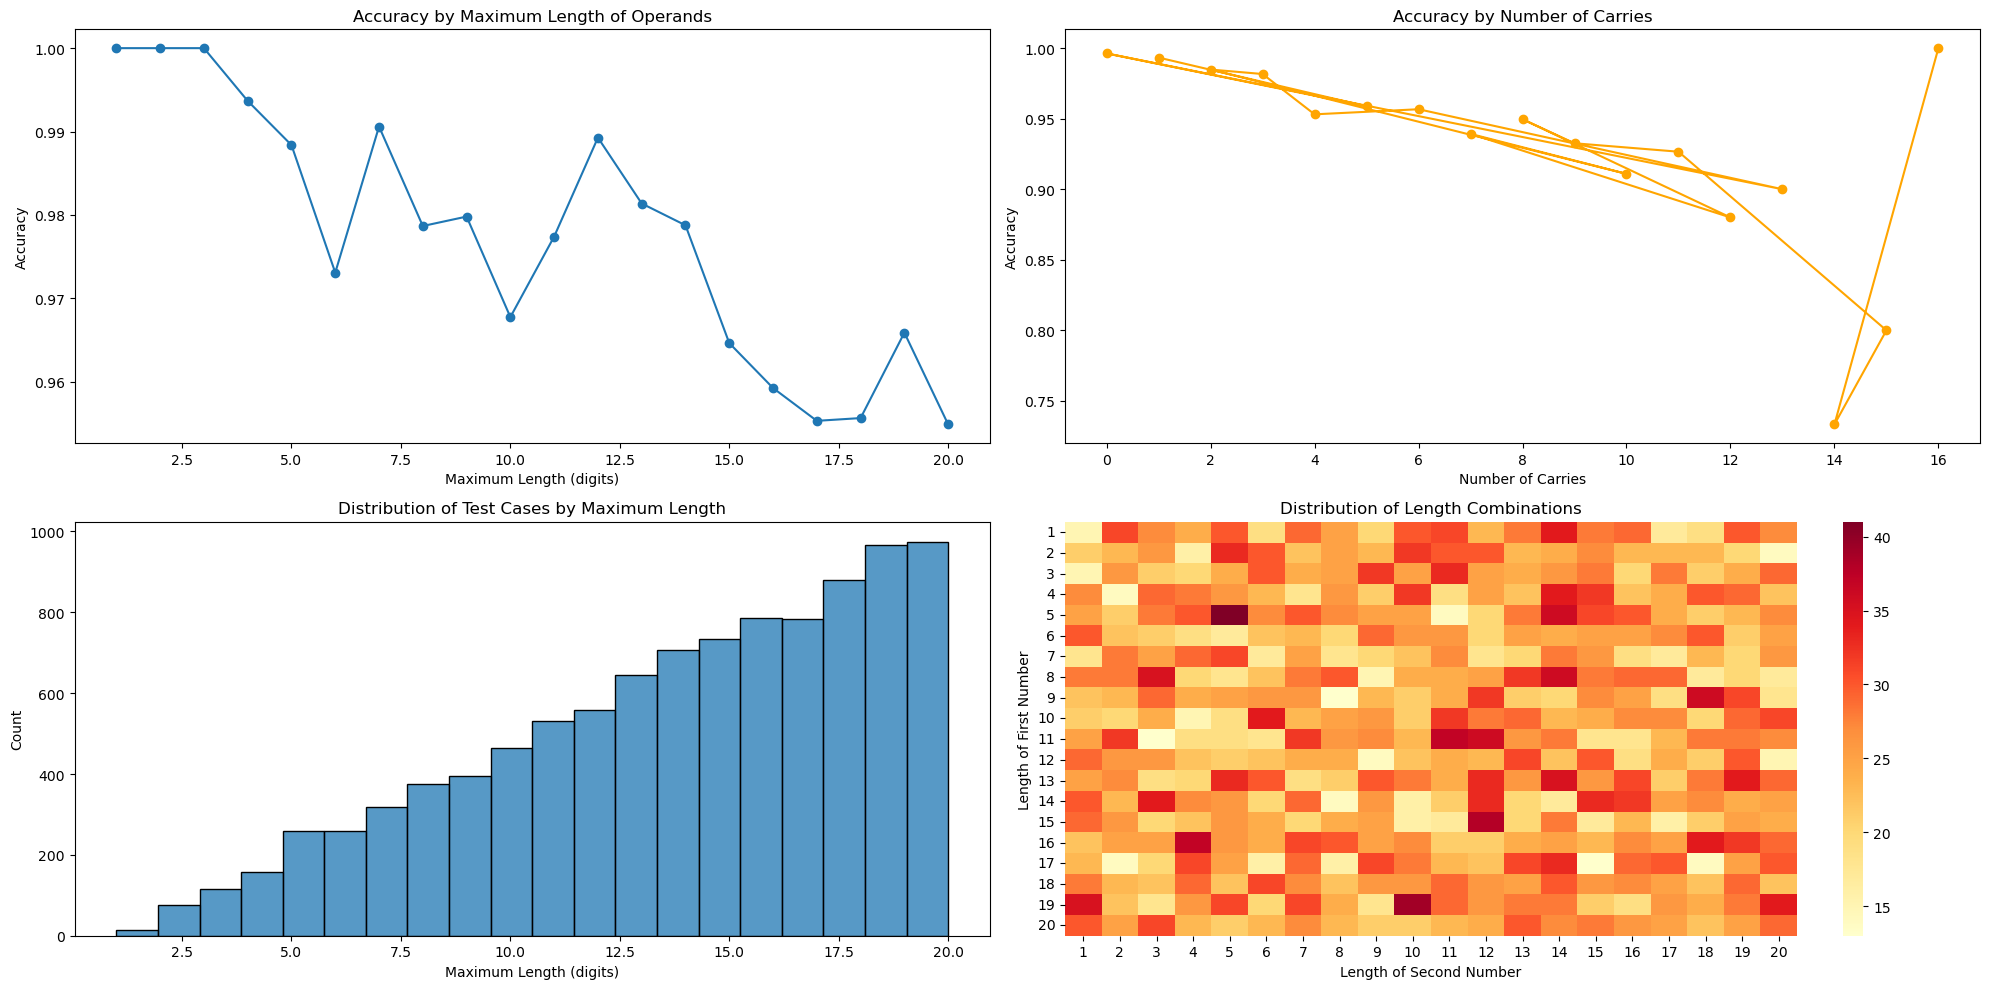


Summary Statistics:
Overall Accuracy: 0.9701
Total Samples: 10000

Detailed Statistics:
Number of correct predictions: 9701
Average number of carries: 3.65

Performance by length ranges:
1-5 digits: 0.9936
6-10 digits: 0.9774
11-15 digits: 0.9776
16-20 digits: 0.9583


In [51]:
# MEDUIM MODEL EVALUATION
# Load model and components
model_path = './Weights/medium_addition_model.pth'  # Update with your model path
model, vocab, inv_vocab, max_seq_length = load_model_and_config(model_path)

# Create evaluator with specific random seed
evaluator = ModelEvaluator(model, vocab, inv_vocab, max_seq_length, random_seed=42)

# Run evaluation
results_df = evaluator.evaluate_model(num_samples=10000)
metrics = evaluator.analyze_results(results_df)

# Visualize results
evaluator.visualize_results(results_df, metrics)

# Save results
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
results_df.to_csv(f'model_evaluation_{timestamp}.csv')

# Print some interesting statistics
print("\nDetailed Statistics:")
print(f"Number of correct predictions: {results_df['is_correct'].sum()}")
print(f"Average number of carries: {results_df['carries'].mean():.2f}")

# Print performance by length ranges
print("\nPerformance by length ranges:")
length_ranges = [(1,5), (6,10), (11,15), (16,20)]
for start, end in length_ranges:
    mask = (results_df['max_len'] >= start) & (results_df['max_len'] <= end)
    acc = results_df[mask]['is_correct'].mean()
    print(f"{start}-{end} digits: {acc:.4f}")

Loading model on cpu
Model configuration: {'vocab_size': 14, 'embed_size': 512, 'num_heads': 8, 'ff_dim': 2048, 'num_layers': 8, 'max_length': 42, 'dropout': 0.15}
Model loaded successfully! Best accuracy: 1.0000


Evaluating Model: 100%|██████████| 10000/10000 [13:21<00:00, 12.47it/s]


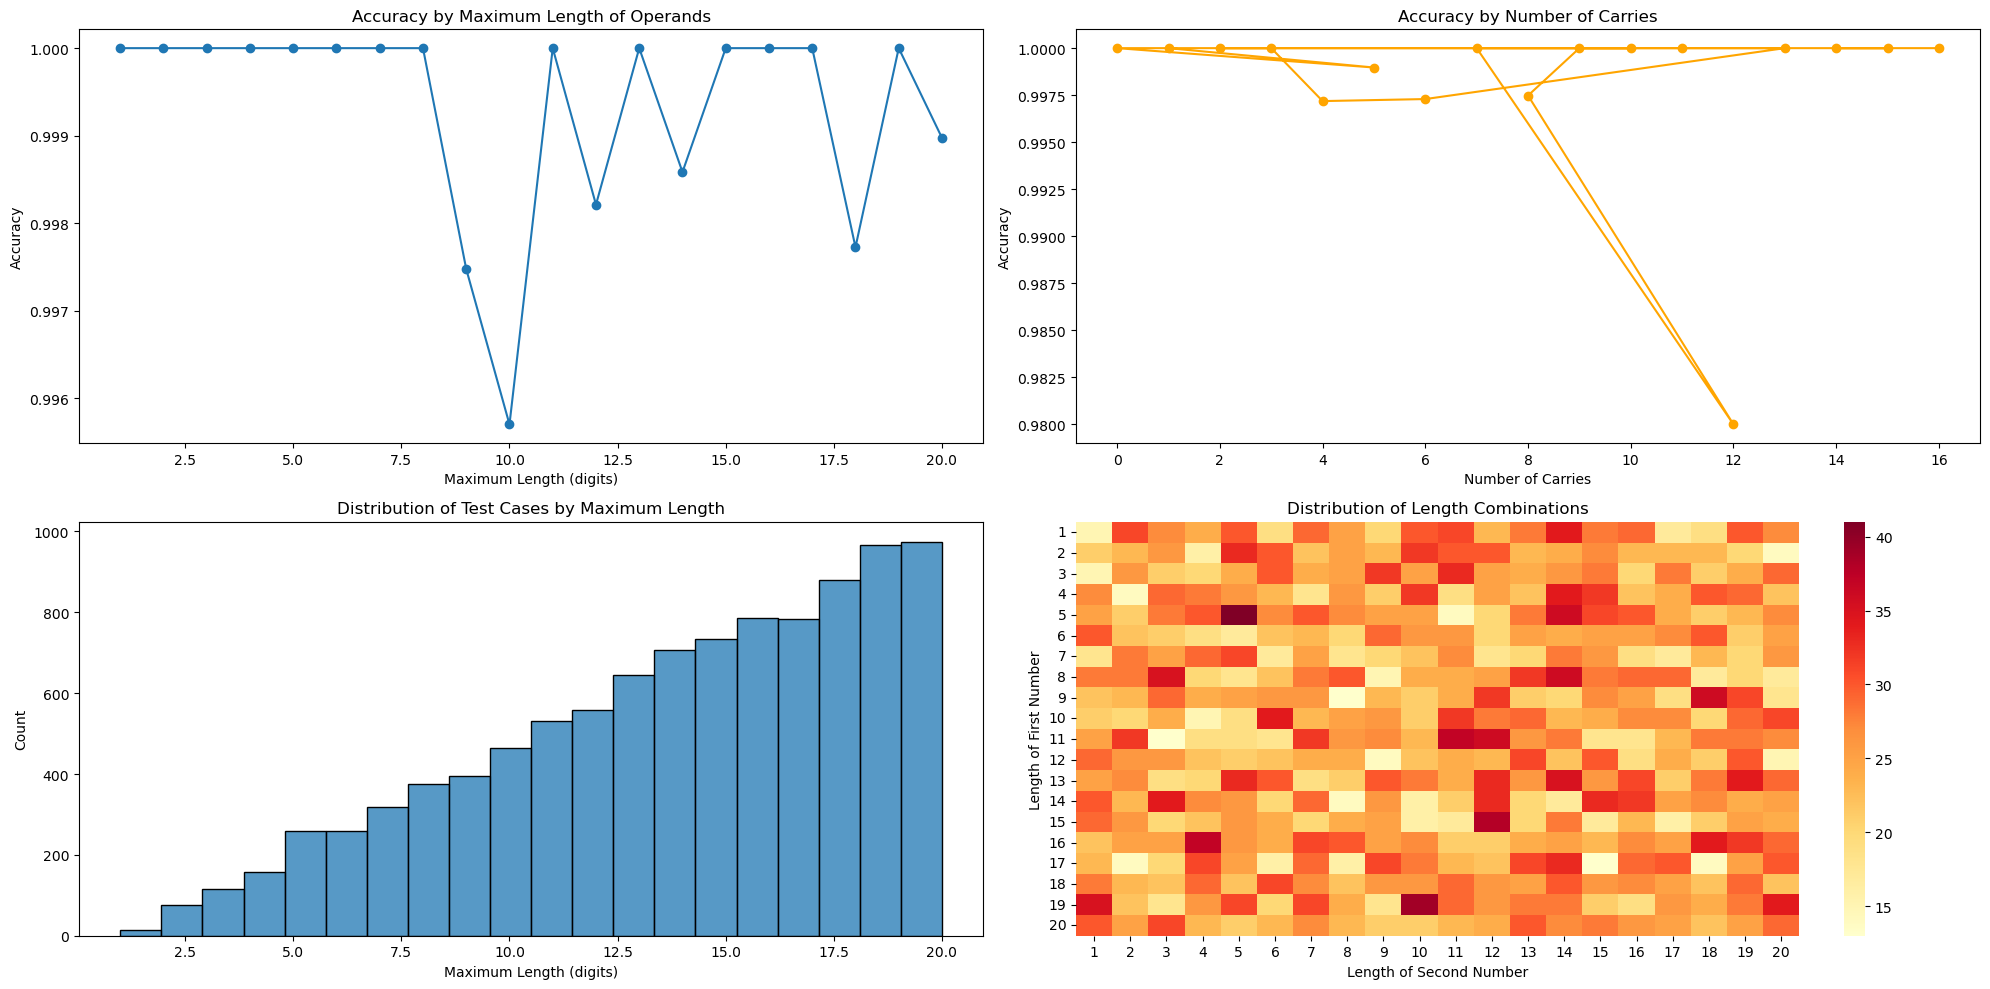


Summary Statistics:
Overall Accuracy: 0.9992
Total Samples: 10000

Detailed Statistics:
Number of correct predictions: 9992
Average number of carries: 3.65

Performance by length ranges:
1-5 digits: 1.0000
6-10 digits: 0.9983
11-15 digits: 0.9994
16-20 digits: 0.9993


In [53]:
# LARGE MODEL EVALUATION
# Load model and components
model_path = './Weights/large_addition_model.pth'  # Update with your model path
model, vocab, inv_vocab, max_seq_length = load_model_and_config(model_path)

# Create evaluator with specific random seed
evaluator = ModelEvaluator(model, vocab, inv_vocab, max_seq_length, random_seed=42)

# Run evaluation
results_df = evaluator.evaluate_model(num_samples=10000)
metrics = evaluator.analyze_results(results_df)

# Visualize results
evaluator.visualize_results(results_df, metrics)

# Save results
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
results_df.to_csv(f'model_evaluation_{timestamp}.csv')

# Print some interesting statistics
print("\nDetailed Statistics:")
print(f"Number of correct predictions: {results_df['is_correct'].sum()}")
print(f"Average number of carries: {results_df['carries'].mean():.2f}")

# Print performance by length ranges
print("\nPerformance by length ranges:")
length_ranges = [(1,5), (6,10), (11,15), (16,20)]
for start, end in length_ranges:
    mask = (results_df['max_len'] >= start) & (results_df['max_len'] <= end)
    acc = results_df[mask]['is_correct'].mean()
    print(f"{start}-{end} digits: {acc:.4f}")

In [7]:
# Helper functions for extended range testing
def generate_extended_test_case(min_digits=21, max_digits=25):
    """Generate a test case with specific digit length"""
    len1 = random.randint(min_digits, max_digits)
    len2 = random.randint(min_digits, max_digits)
    num1 = random.randint(10**(len1-1), (10**len1) - 1)
    num2 = random.randint(10**(len2-1), (10**len2) - 1)
    return num1, num2, len1, len2

class ExtendedRangeEvaluator(ModelEvaluator):
    def evaluate_model(self, samples_per_length=200):
        """
        Evaluate model with uniform distribution across 21-25 digits
        """
        results = []
        for target_length in range(21, 26):
            for _ in tqdm(range(samples_per_length), 
                         desc=f"Evaluating {target_length} digits"):
                # Generate numbers
                num1, num2, len1, len2 = generate_extended_test_case(
                    target_length, target_length)
                true_result = num1 + num2
                
                # Get model prediction
                input_str = f"{num1}+{num2}="
                input_tensor = self.preprocess_input(input_str)
                
                with torch.no_grad():
                    output = self.model(input_tensor)
                    pred_str = self.decode_output(output)
                
                try:
                    pred_result = int(pred_str)
                    is_correct = pred_result == true_result
                except ValueError:
                    pred_result = None
                    is_correct = False
                
                results.append({
                    'num1': num1,
                    'num2': num2,
                    'len1': len1,
                    'len2': len2,
                    'max_len': max(len1, len2),
                    'true_result': true_result,
                    'predicted_result': pred_result,
                    'is_correct': is_correct,
                    'carries': self.count_carries(num1, num2)
                })
        
        return pd.DataFrame(results)

# SMALL MODEL EXTENDED RANGE EVALUATION
Loading model on cpu
Model configuration: {'vocab_size': 14, 'embed_size': 64, 'num_heads': 2, 'ff_dim': 256, 'num_layers': 2, 'max_length': 42, 'dropout': 0.1}
Model loaded successfully! Best accuracy: 0.7937


Evaluating 25 digits: 100%|██████████| 200/200 [00:01<00:00, 169.77it/s]


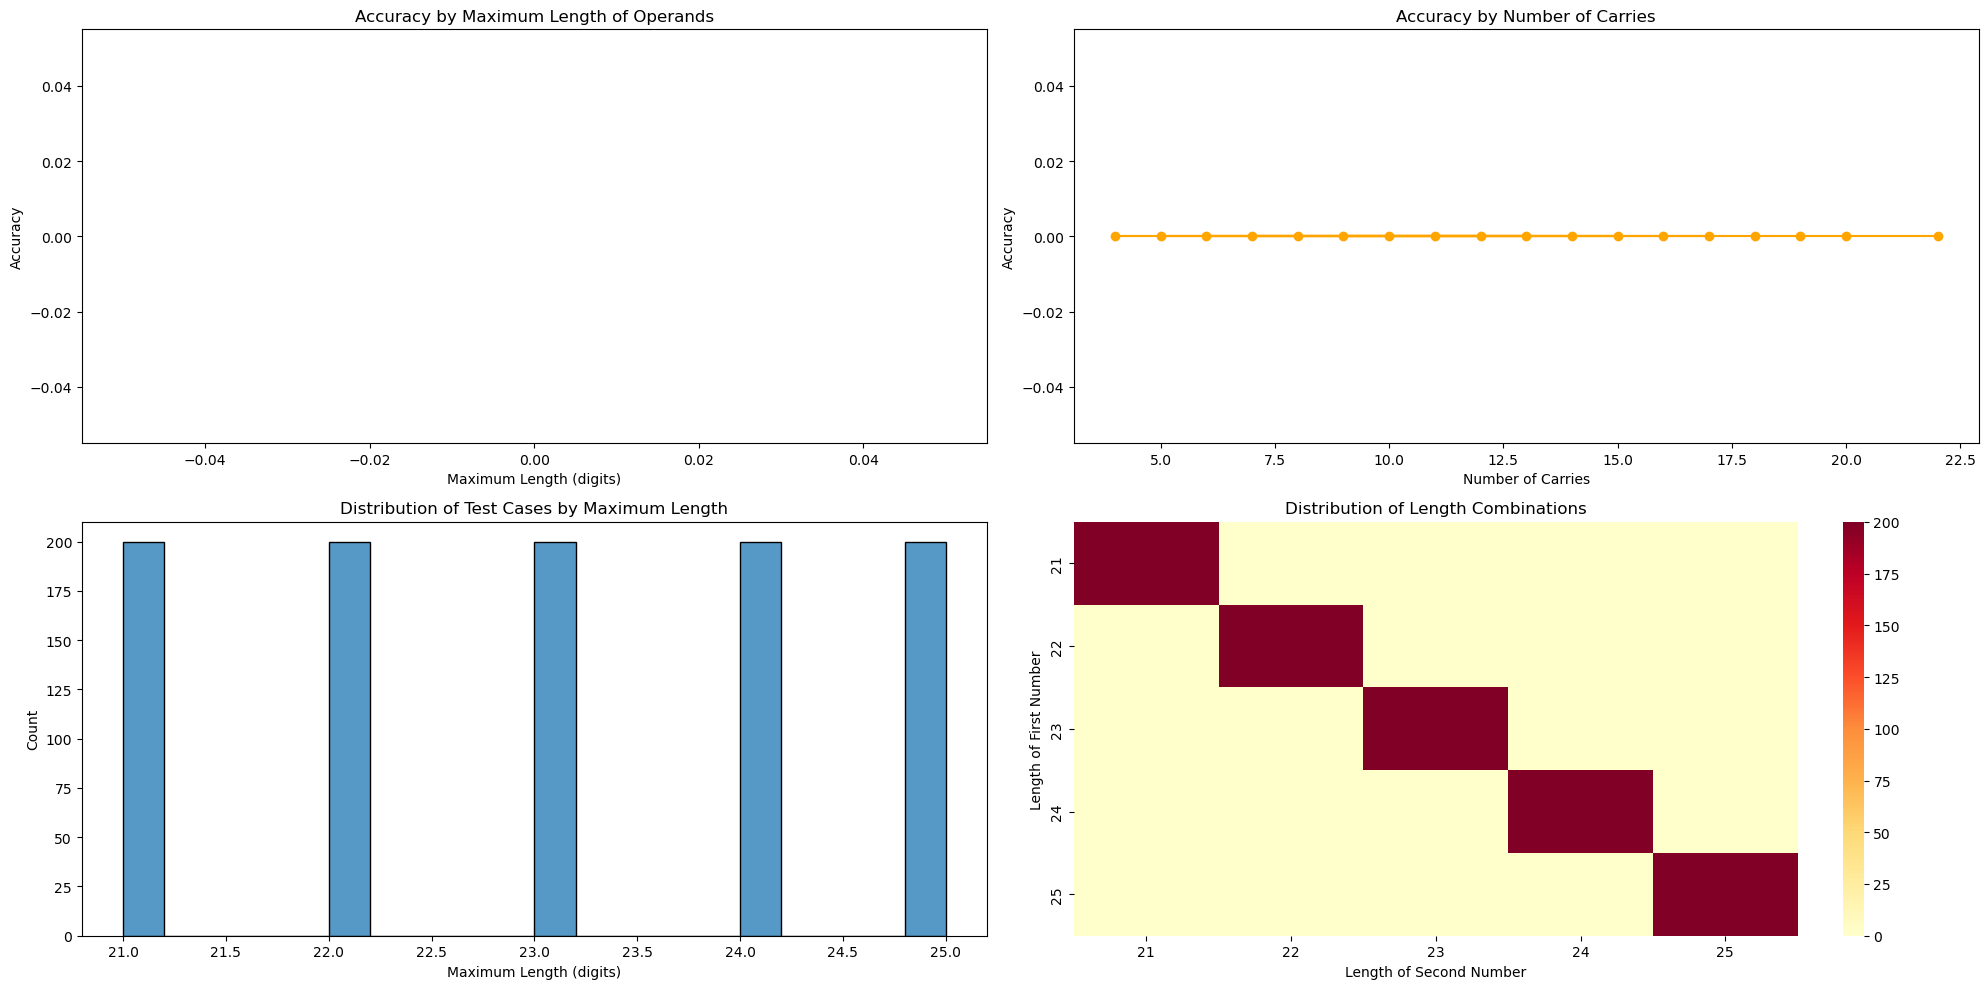


Summary Statistics:
Overall Accuracy: 0.0000
Total Samples: 1000

Detailed Statistics:
Number of correct predictions: 0
Average number of carries: 11.56

Performance by length:
21 digits: 0.0000 (200 samples)
22 digits: 0.0000 (200 samples)
23 digits: 0.0000 (200 samples)
24 digits: 0.0000 (200 samples)
25 digits: 0.0000 (200 samples)


In [11]:
# First cell: SMALL MODEL EXTENDED RANGE EVALUATION
print("# SMALL MODEL EXTENDED RANGE EVALUATION")
# Load model and components
model_path = './Weights/small_addition_model.pth'
model, vocab, inv_vocab, max_seq_length = load_model_and_config(model_path)

# Create evaluator
evaluator = ExtendedRangeEvaluator(model, vocab, inv_vocab, max_seq_length, random_seed=42)

# Run evaluation
results_df = evaluator.evaluate_model(samples_per_length=200)
metrics = evaluator.analyze_results(results_df)

# Visualize results
evaluator.visualize_results(results_df, metrics)

# Save results
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
results_df.to_csv(f'extended_small_model_evaluation_{timestamp}.csv')

# Print statistics
print("\nDetailed Statistics:")
print(f"Number of correct predictions: {results_df['is_correct'].sum()}")
print(f"Average number of carries: {results_df['carries'].mean():.2f}")

print("\nPerformance by length:")
for length in range(21, 26):
    mask = (results_df['max_len'] == length)
    acc = results_df[mask]['is_correct'].mean()
    samples = sum(mask)
    print(f"{length} digits: {acc:.4f} ({samples} samples)")




# MEDIUM MODEL EXTENDED RANGE EVALUATION
Loading model on cpu
Model configuration: {'vocab_size': 14, 'embed_size': 256, 'num_heads': 4, 'ff_dim': 1024, 'num_layers': 4, 'max_length': 42, 'dropout': 0.1}
Model loaded successfully! Best accuracy: 0.9987


Evaluating 25 digits: 100%|██████████| 200/200 [00:03<00:00, 59.23it/s]


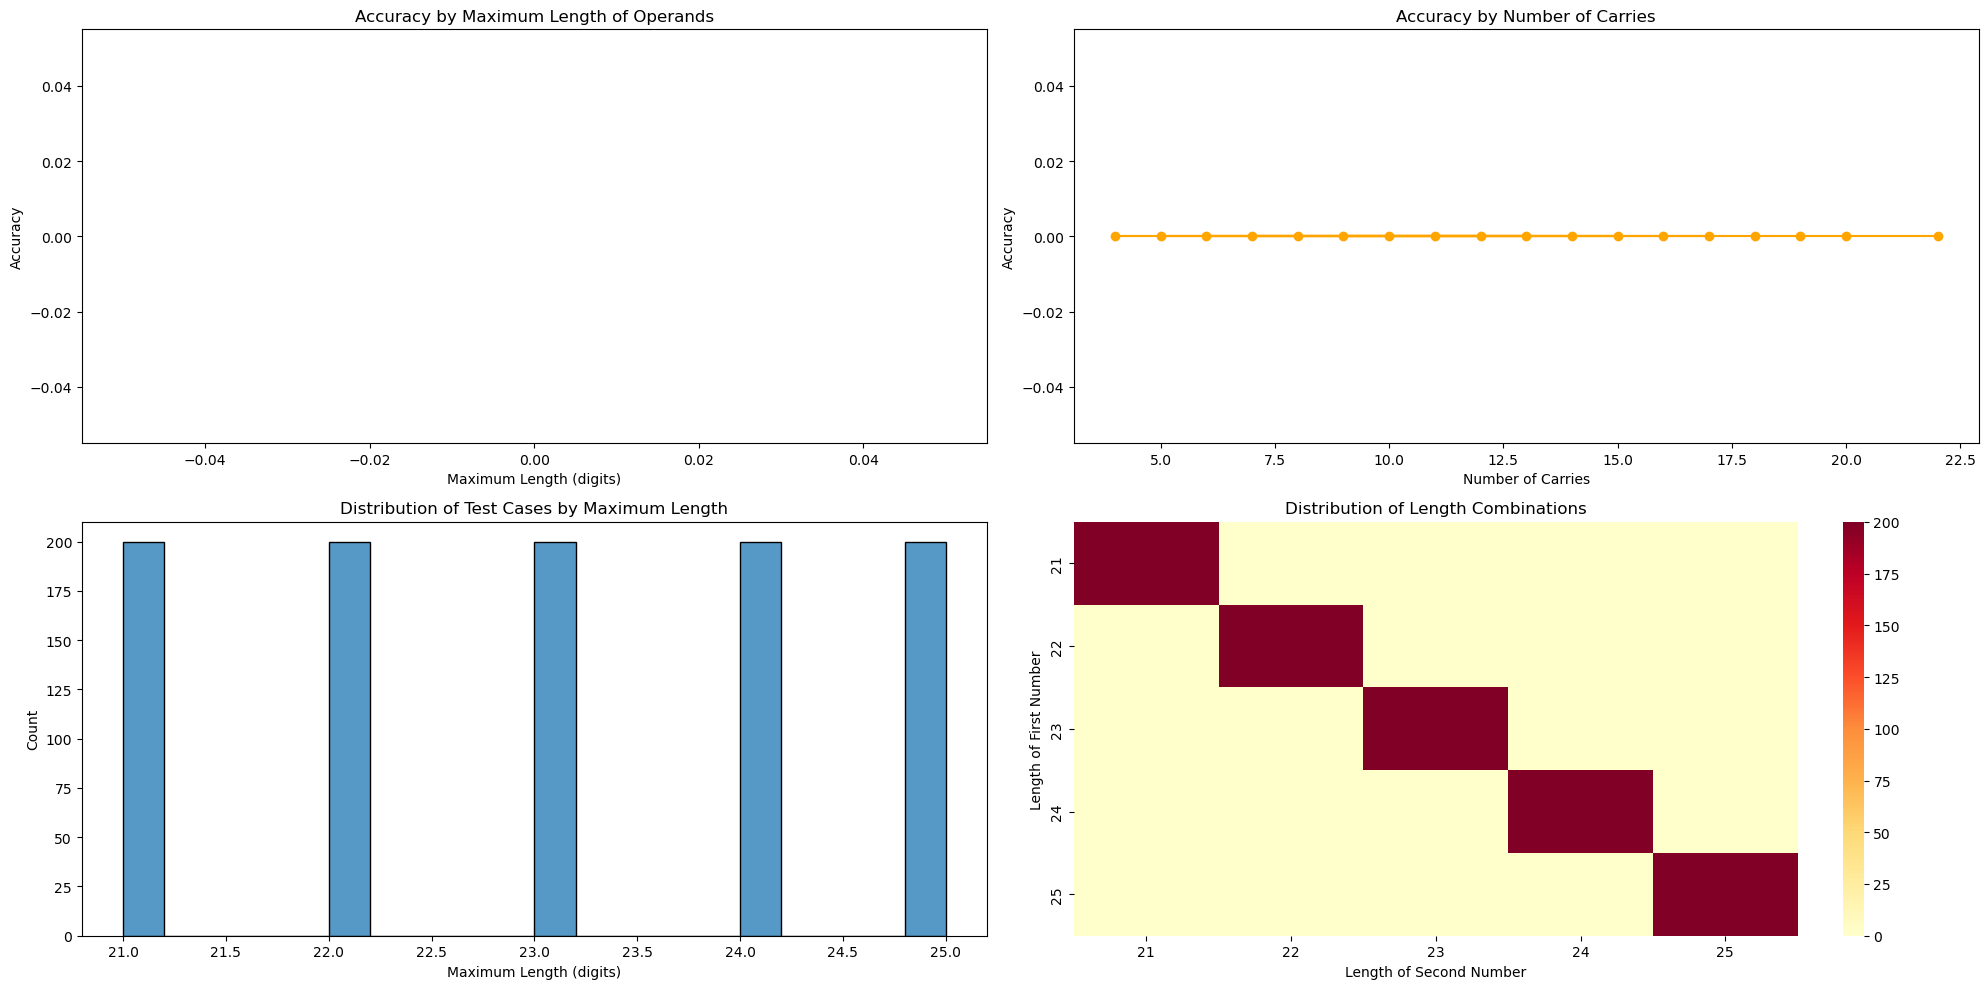


Summary Statistics:
Overall Accuracy: 0.0000
Total Samples: 1000

Detailed Statistics:
Number of correct predictions: 0
Average number of carries: 11.56

Performance by length:
21 digits: 0.0000 (200 samples)
22 digits: 0.0000 (200 samples)
23 digits: 0.0000 (200 samples)
24 digits: 0.0000 (200 samples)
25 digits: 0.0000 (200 samples)


In [12]:
# Second cell: MEDIUM MODEL EXTENDED RANGE EVALUATION
print("\n# MEDIUM MODEL EXTENDED RANGE EVALUATION")
# Load model and components
model_path = './Weights/medium_addition_model.pth'
model, vocab, inv_vocab, max_seq_length = load_model_and_config(model_path)

# Create evaluator
evaluator = ExtendedRangeEvaluator(model, vocab, inv_vocab, max_seq_length, random_seed=42)

# Run evaluation
results_df = evaluator.evaluate_model(samples_per_length=200)
metrics = evaluator.analyze_results(results_df)

# Visualize results
evaluator.visualize_results(results_df, metrics)

# Save results
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
results_df.to_csv(f'extended_medium_model_evaluation_{timestamp}.csv')

# Print statistics
print("\nDetailed Statistics:")
print(f"Number of correct predictions: {results_df['is_correct'].sum()}")
print(f"Average number of carries: {results_df['carries'].mean():.2f}")

print("\nPerformance by length:")
for length in range(21, 26):
    mask = (results_df['max_len'] == length)
    acc = results_df[mask]['is_correct'].mean()
    samples = sum(mask)
    print(f"{length} digits: {acc:.4f} ({samples} samples)")



# LARGE MODEL EXTENDED RANGE EVALUATION
Loading model on cpu
Model configuration: {'vocab_size': 14, 'embed_size': 512, 'num_heads': 8, 'ff_dim': 2048, 'num_layers': 8, 'max_length': 42, 'dropout': 0.15}
Model loaded successfully! Best accuracy: 1.0000


Evaluating 25 digits: 100%|██████████| 200/200 [00:14<00:00, 13.62it/s]


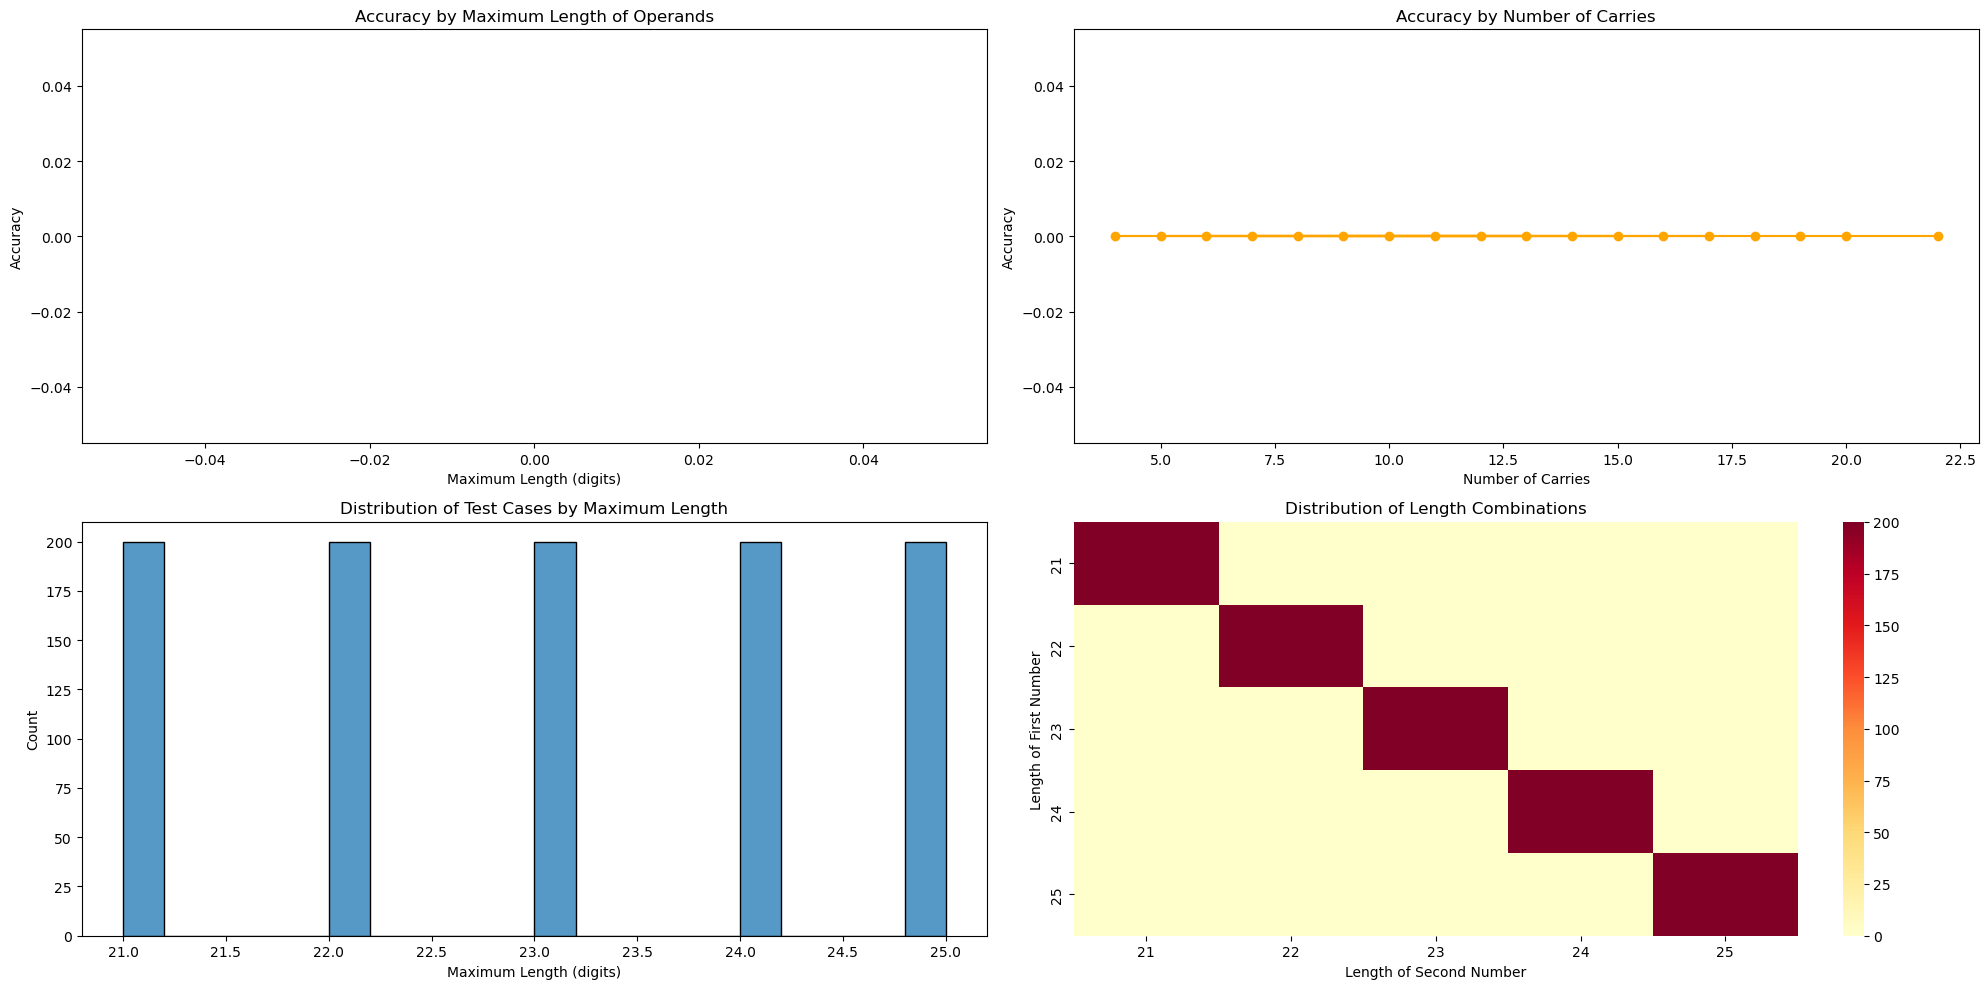


Summary Statistics:
Overall Accuracy: 0.0000
Total Samples: 1000

Detailed Statistics:
Number of correct predictions: 0
Average number of carries: 11.56

Performance by length:
21 digits: 0.0000 (200 samples)
22 digits: 0.0000 (200 samples)
23 digits: 0.0000 (200 samples)
24 digits: 0.0000 (200 samples)
25 digits: 0.0000 (200 samples)


In [13]:
# Third cell: LARGE MODEL EXTENDED RANGE EVALUATION
print("\n# LARGE MODEL EXTENDED RANGE EVALUATION")
# Load model and components
model_path = './Weights/large_addition_model.pth'
model, vocab, inv_vocab, max_seq_length = load_model_and_config(model_path)

# Create evaluator
evaluator = ExtendedRangeEvaluator(model, vocab, inv_vocab, max_seq_length, random_seed=42)

# Run evaluation
results_df = evaluator.evaluate_model(samples_per_length=200)
metrics = evaluator.analyze_results(results_df)

# Visualize results
evaluator.visualize_results(results_df, metrics)

# Save results
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
results_df.to_csv(f'extended_large_model_evaluation_{timestamp}.csv')

# Print statistics
print("\nDetailed Statistics:")
print(f"Number of correct predictions: {results_df['is_correct'].sum()}")
print(f"Average number of carries: {results_df['carries'].mean():.2f}")

print("\nPerformance by length:")
for length in range(21, 26):
    mask = (results_df['max_len'] == length)
    acc = results_df[mask]['is_correct'].mean()
    samples = sum(mask)
    print(f"{length} digits: {acc:.4f} ({samples} samples)")

In [20]:
# Import necessary libraries
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
from datetime import datetime

class ComprehensiveEvaluator(ModelEvaluator):
    def evaluate_model(self, samples_per_length=100):
        """
        Evaluate model with multiple metrics per Schaeffer et al.
        - Traditional accuracy (discontinuous)
        - Token edit distance (linear)
        - Per-token probability (continuous)
        - Brier score for digit prediction (continuous)
        """
        results = []
        digit_lengths = range(1, 21)  # Testing on 1-20 digit numbers
        
        for target_length in digit_lengths:
            for _ in tqdm(range(samples_per_length), 
                         desc=f"Evaluating {target_length} digits"):
                # Generate numbers with exact target length
                num1 = random.randint(10**(target_length-1), 10**target_length - 1)
                num2 = random.randint(10**(target_length-1), 10**target_length - 1)
                true_result = num1 + num2
                
                # Get model prediction
                input_str = f"{num1}+{num2}="
                input_tensor = self.preprocess_input(input_str)
                
                with torch.no_grad():
                    output = self.model(input_tensor)
                    logits = F.softmax(output, dim=-1)
                    pred_str = self.decode_output(output)
                
                try:
                    pred_result = int(pred_str)
                    is_correct = pred_result == true_result
                except ValueError:
                    pred_result = None
                    is_correct = False
                
                # Calculate additional metrics
                target_tokens = str(true_result)
                pred_tokens = str(pred_result) if pred_result is not None else ""
                edit_distance = self.calculate_token_edit_distance(target_tokens, pred_tokens)
                target_token_probs = self.calculate_target_token_probs(logits, str(true_result))
                brier_score = self.calculate_brier_score(logits, str(true_result))
                
                results.append({
                    'num1': num1,
                    'num2': num2,
                    'len1': len(str(num1)),
                    'len2': len(str(num2)),
                    'max_len': max(len(str(num1)), len(str(num2))),
                    'true_result': true_result,
                    'predicted_result': pred_result,
                    'is_correct': is_correct,
                    'carries': self.count_carries(num1, num2),
                    'edit_distance': edit_distance,
                    'mean_token_prob': np.mean(target_token_probs),
                    'brier_score': brier_score
                })
        
        return pd.DataFrame(results)
    
    def calculate_token_edit_distance(self, target, pred):
        """Calculate minimum number of token operations to transform pred into target"""
        m, n = len(target), len(pred)
        dp = [[0] * (n + 1) for _ in range(m + 1)]
        
        for i in range(m + 1):
            dp[i][0] = i
        for j in range(n + 1):
            dp[0][j] = j
            
        for i in range(1, m + 1):
            for j in range(1, n + 1):
                if target[i-1] == pred[j-1]:
                    dp[i][j] = dp[i-1][j-1]
                else:
                    dp[i][j] = min(dp[i-1][j], dp[i][j-1], dp[i-1][j-1]) + 1
        
        return dp[m][n]
    
    def calculate_target_token_probs(self, logits, target):
        """Calculate probability model assigned to each correct target token"""
        probs = []
        for i, digit in enumerate(target):
            if i < logits.size(1):  # Ensure we don't exceed sequence length
                digit_idx = self.vocab[digit]
                prob = logits[0, i, digit_idx].item()
                probs.append(prob)
        return probs
    
    def calculate_brier_score(self, logits, target):
        """Calculate Brier score for digit prediction"""
        brier_scores = []
        for i, digit in enumerate(target):
            if i < logits.size(1):
                target_dist = torch.zeros_like(logits[0, i])
                target_dist[self.vocab[digit]] = 1.0
                brier_scores.append(torch.mean((logits[0, i] - target_dist)**2).item())
        return np.mean(brier_scores)

def analyze_and_visualize_results(results_df, model_name):
    """Generate visualizations and save reports for a model's evaluation results"""
    # Save raw results
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    results_df.to_csv(f'{model_name}_raw_results_{timestamp}.csv')
    
    # Calculate aggregated statistics
    agg_stats = {}
    
    # Overall metrics
    agg_stats['overall'] = {
        'accuracy': results_df['is_correct'].mean(),
        'edit_distance': results_df['edit_distance'].mean(),
        'token_probability': results_df['mean_token_prob'].mean(),
        'brier_score': results_df['brier_score'].mean()
    }
    
    # Metrics by length range
    length_ranges = [(1,5), (6,10), (11,15), (16,20)]
    for start, end in length_ranges:
        mask = (results_df['max_len'] >= start) & (results_df['max_len'] <= end)
        range_name = f'length_{start}_to_{end}'
        agg_stats[range_name] = {
            'accuracy': results_df[mask]['is_correct'].mean(),
            'edit_distance': results_df[mask]['edit_distance'].mean(),
            'token_probability': results_df[mask]['mean_token_prob'].mean(),
            'brier_score': results_df[mask]['brier_score'].mean()
        }
    
    # Save aggregated statistics
    pd.DataFrame(agg_stats).to_csv(f'{model_name}_aggregated_stats_{timestamp}.csv')
    
    # Visualization
    plt.figure(figsize=(20, 10))

    # Plot 1: Traditional Accuracy (Discontinuous)
    plt.subplot(2, 2, 1)
    accuracy_by_length = results_df.groupby('max_len')['is_correct'].mean()
    plt.plot(accuracy_by_length.index, accuracy_by_length.values, marker='o')
    plt.title(f'{model_name}: Traditional Accuracy by Length\n(Discontinuous Metric)')
    plt.xlabel('Number Length (digits)')
    plt.ylabel('Accuracy')

    # Plot 2: Token Edit Distance (Linear)
    plt.subplot(2, 2, 2)
    edit_distance_by_length = -results_df.groupby('max_len')['edit_distance'].mean()
    plt.plot(edit_distance_by_length.index, edit_distance_by_length.values, marker='o')
    plt.title(f'{model_name}: Token Edit Distance by Length\n(Linear Metric)')
    plt.xlabel('Number Length (digits)')
    plt.ylabel('Negative Edit Distance')

    # Plot 3: Mean Token Probability (Continuous)
    plt.subplot(2, 2, 3)
    prob_by_length = results_df.groupby('max_len')['mean_token_prob'].mean()
    plt.plot(prob_by_length.index, prob_by_length.values, marker='o')
    plt.title(f'{model_name}: Mean Token Probability by Length\n(Continuous Metric)')
    plt.xlabel('Number Length (digits)')
    plt.ylabel('Mean Probability')

    # Plot 4: Brier Score (Continuous)
    plt.subplot(2, 2, 4)
    brier_by_length = -results_df.groupby('max_len')['brier_score'].mean()
    plt.plot(brier_by_length.index, brier_by_length.values, marker='o')
    plt.title(f'{model_name}: Brier Score by Length\n(Continuous Metric)')
    plt.xlabel('Number Length (digits)')
    plt.ylabel('Negative Brier Score')

    plt.tight_layout()
    plt.savefig(f'{model_name}_analysis_plots_{timestamp}.png')
    plt.show()
    
    # Print summary statistics
    print(f"\nDetailed Statistics for {model_name}:")
    print(f"Number of samples: {len(results_df)}")
    print("\nPerformance by metric type:")
    print("\nDiscontinuous Metrics:")
    print(f"Overall Accuracy: {agg_stats['overall']['accuracy']:.4f}")
    
    print("\nLinear Metrics:")
    print(f"Mean Edit Distance: {agg_stats['overall']['edit_distance']:.4f}")
    
    print("\nContinuous Metrics:")
    print(f"Mean Token Probability: {agg_stats['overall']['token_probability']:.4f}")
    print(f"Mean Brier Score: {agg_stats['overall']['brier_score']:.4f}")
    
    print("\nPerformance by length ranges:")
    for start, end in length_ranges:
        range_name = f'length_{start}_to_{end}'
        print(f"\n{start}-{end} digits:")
        print(f"  Accuracy: {agg_stats[range_name]['accuracy']:.4f}")
        print(f"  Edit Distance: {agg_stats[range_name]['edit_distance']:.4f}")
        print(f"  Token Probability: {agg_stats[range_name]['token_probability']:.4f}")
        print(f"  Brier Score: {agg_stats[range_name]['brier_score']:.4f}")


# SMALL MODEL COMPREHENSIVE ANALYSIS
Loading model on cpu
Model configuration: {'vocab_size': 14, 'embed_size': 64, 'num_heads': 2, 'ff_dim': 256, 'num_layers': 2, 'max_length': 42, 'dropout': 0.1}
Model loaded successfully! Best accuracy: 0.7937


Evaluating 20 digits: 100%|██████████| 100/100 [00:00<00:00, 104.53it/s]


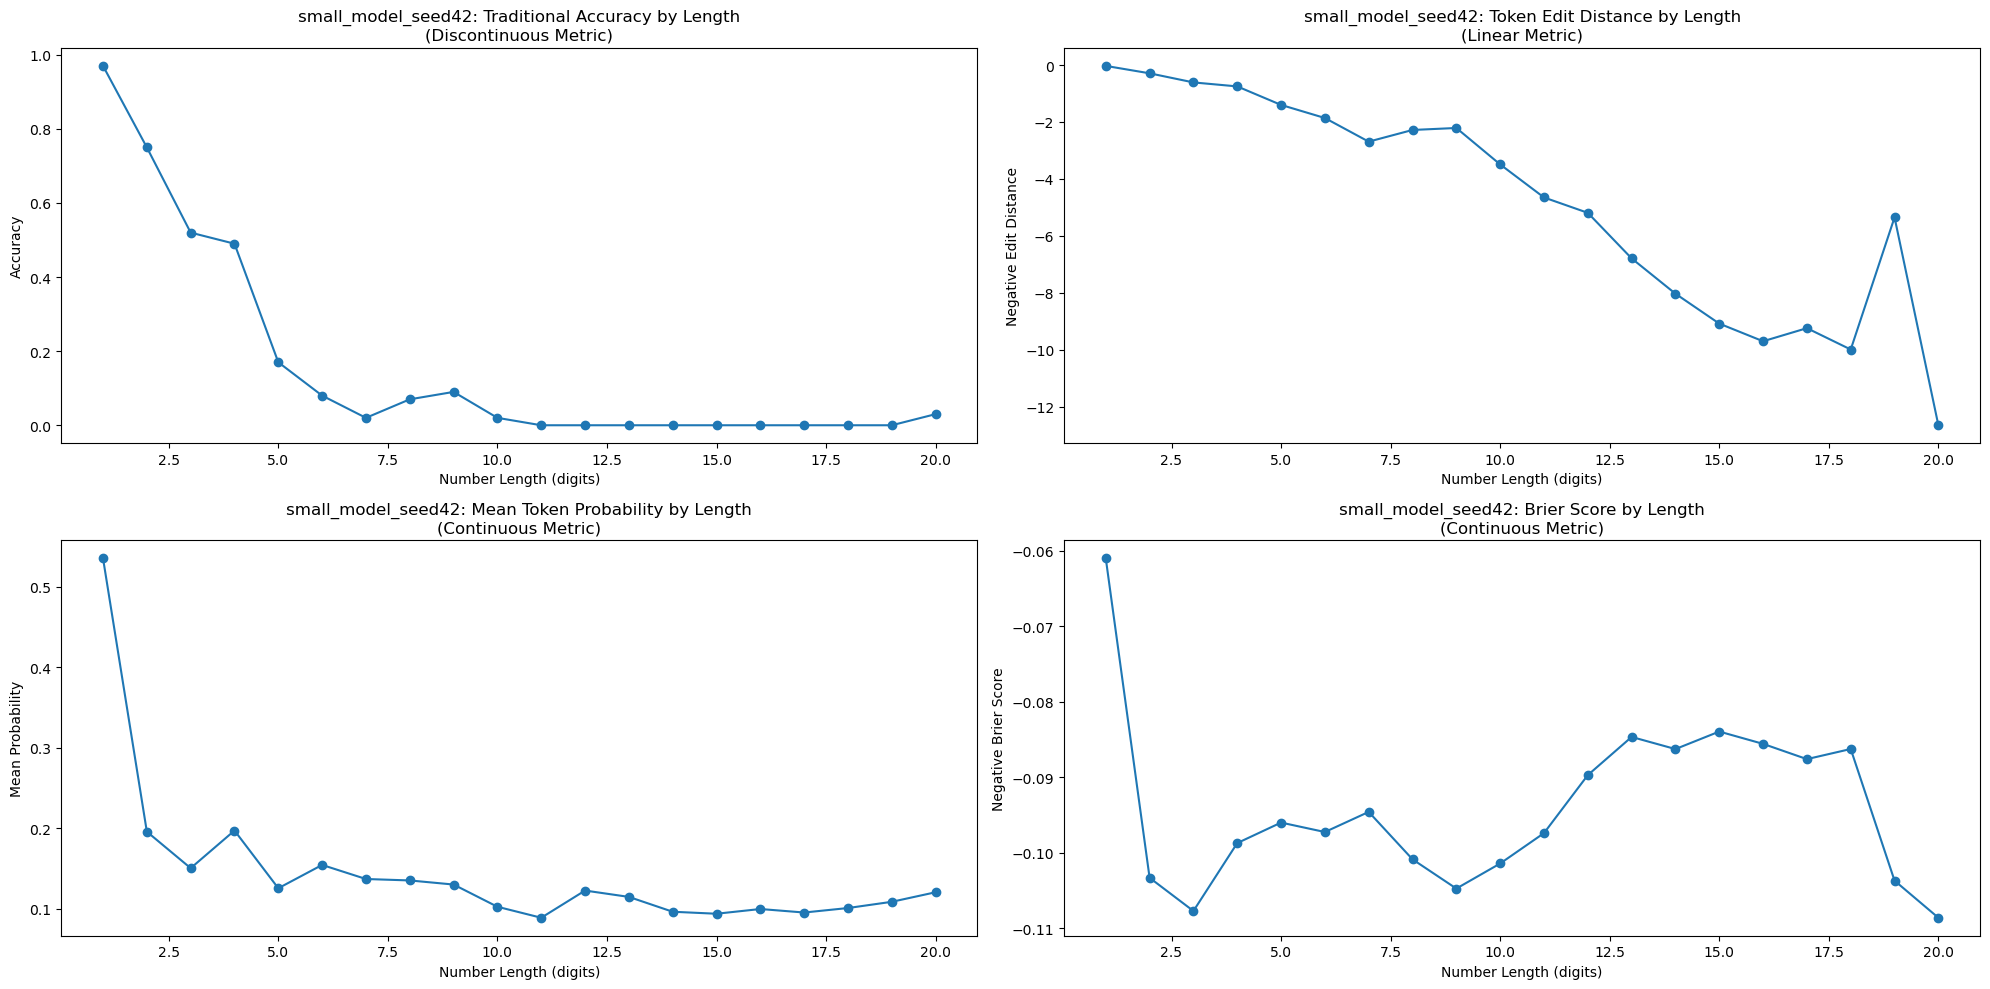


Detailed Statistics for small_model_seed42:
Number of samples: 2000

Performance by metric type:

Discontinuous Metrics:
Overall Accuracy: 0.1605

Linear Metrics:
Mean Edit Distance: 4.8140

Continuous Metrics:
Mean Token Probability: 0.1451
Mean Brier Score: 0.0940

Performance by length ranges:

1-5 digits:
  Accuracy: 0.5800
  Edit Distance: 0.6160
  Token Probability: 0.2406
  Brier Score: 0.0934

6-10 digits:
  Accuracy: 0.0560
  Edit Distance: 2.5060
  Token Probability: 0.1317
  Brier Score: 0.0998

11-15 digits:
  Accuracy: 0.0000
  Edit Distance: 6.7480
  Token Probability: 0.1031
  Brier Score: 0.0884

16-20 digits:
  Accuracy: 0.0060
  Edit Distance: 9.3860
  Token Probability: 0.1049
  Brier Score: 0.0943


In [22]:
# SMALL MODEL COMPREHENSIVE ANALYSIS
print("\n# SMALL MODEL COMPREHENSIVE ANALYSIS")

# Load model and components
model_path = './Weights/small_addition_model.pth'
model, vocab, inv_vocab, max_seq_length = load_model_and_config(model_path)

# Create evaluator with specific random seed for test generation
evaluator = ComprehensiveEvaluator(model, vocab, inv_vocab, max_seq_length, random_seed=42)

# Run evaluation
results_df = evaluator.evaluate_model(samples_per_length=100)

# Generate visualizations and save reports
analyze_and_visualize_results(results_df, "small_model_seed42")



# MEDIUM MODEL COMPREHENSIVE ANALYSIS
Loading model on cpu
Model configuration: {'vocab_size': 14, 'embed_size': 256, 'num_heads': 4, 'ff_dim': 1024, 'num_layers': 4, 'max_length': 42, 'dropout': 0.1}
Model loaded successfully! Best accuracy: 0.9987


Evaluating 20 digits: 100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


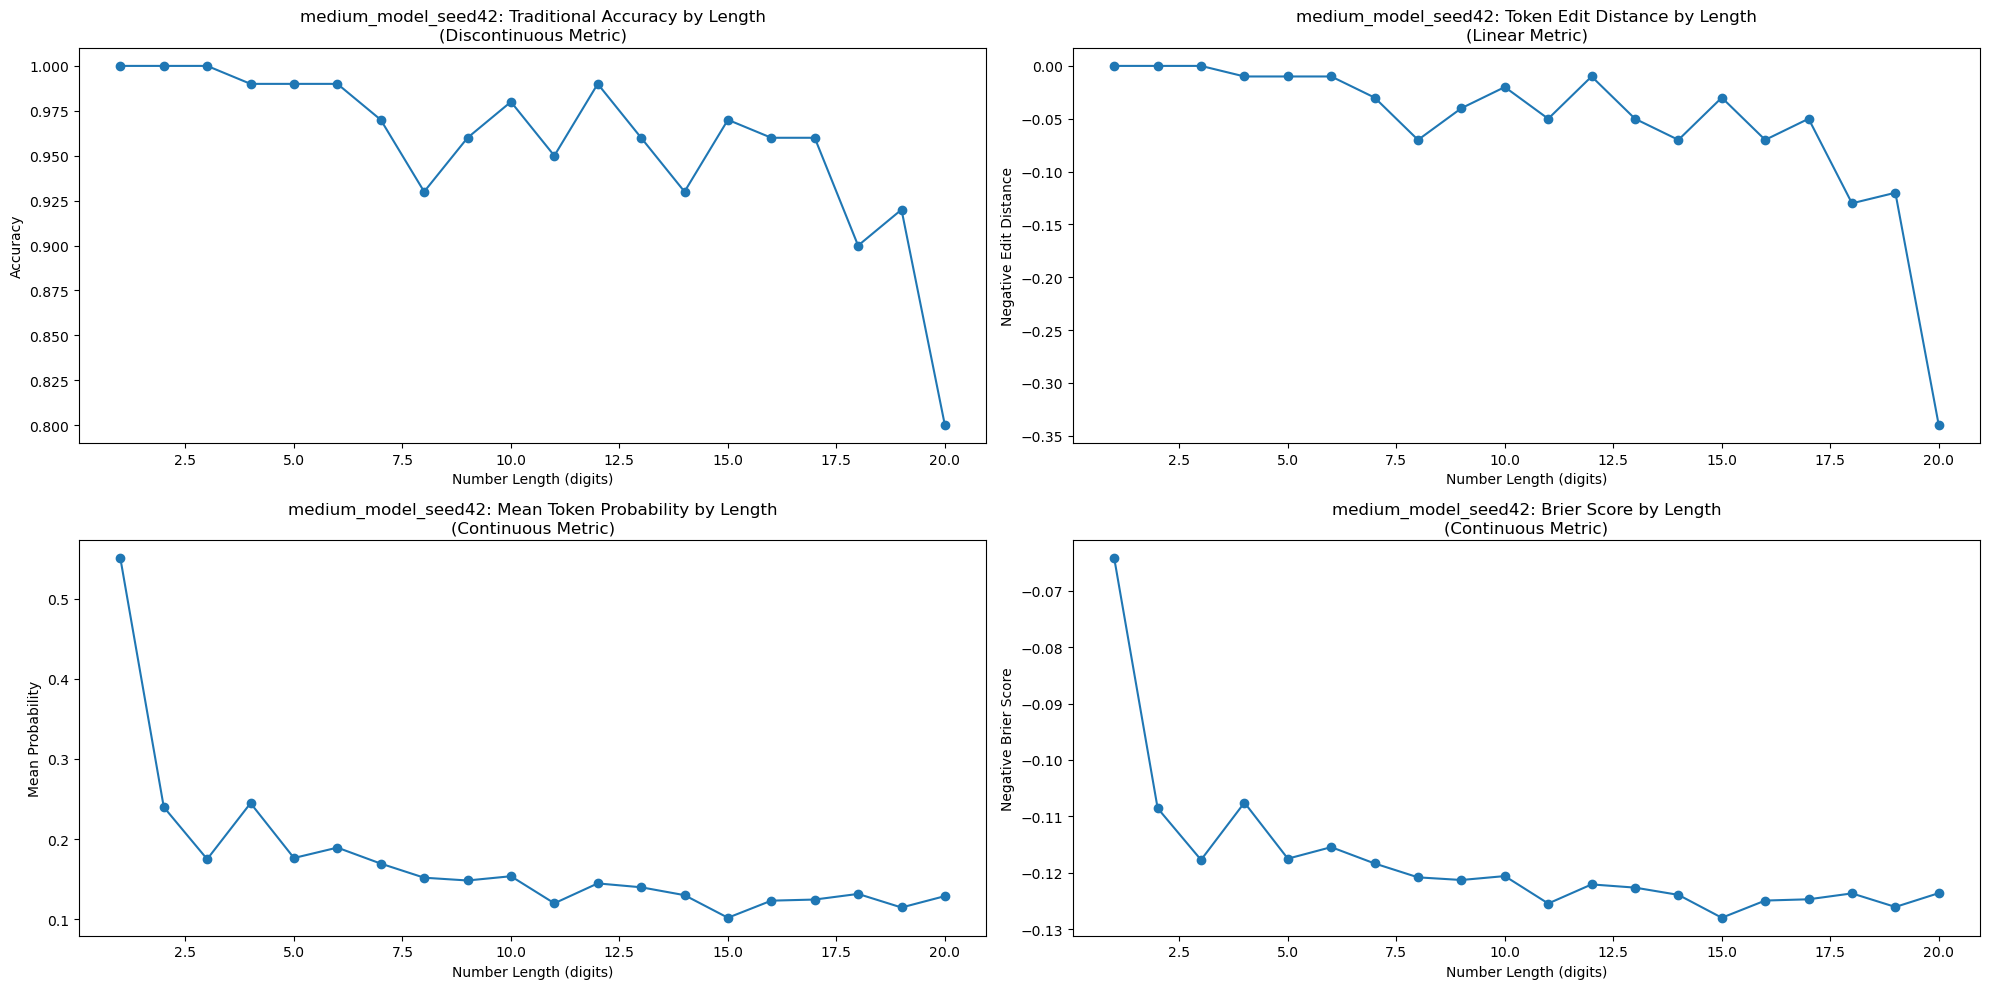


Detailed Statistics for medium_model_seed42:
Number of samples: 2000

Performance by metric type:

Discontinuous Metrics:
Overall Accuracy: 0.9575

Linear Metrics:
Mean Edit Distance: 0.0555

Continuous Metrics:
Mean Token Probability: 0.1730
Mean Brier Score: 0.1179

Performance by length ranges:

1-5 digits:
  Accuracy: 0.9960
  Edit Distance: 0.0040
  Token Probability: 0.2773
  Brier Score: 0.1031

6-10 digits:
  Accuracy: 0.9660
  Edit Distance: 0.0340
  Token Probability: 0.1626
  Brier Score: 0.1193

11-15 digits:
  Accuracy: 0.9600
  Edit Distance: 0.0420
  Token Probability: 0.1274
  Brier Score: 0.1244

16-20 digits:
  Accuracy: 0.9080
  Edit Distance: 0.1420
  Token Probability: 0.1247
  Brier Score: 0.1246


In [23]:
# MEDIUM MODEL COMPREHENSIVE ANALYSIS
print("\n# MEDIUM MODEL COMPREHENSIVE ANALYSIS")

# Load model and components
model_path = './Weights/medium_addition_model.pth'
model, vocab, inv_vocab, max_seq_length = load_model_and_config(model_path)

# Create evaluator with different random seed
evaluator = ComprehensiveEvaluator(model, vocab, inv_vocab, max_seq_length, random_seed=42)

# Run evaluation
results_df = evaluator.evaluate_model(samples_per_length=100)

# Generate visualizations and save reports
analyze_and_visualize_results(results_df, "medium_model_seed42")


# LARGE MODEL COMPREHENSIVE ANALYSIS
Loading model on cpu
Model configuration: {'vocab_size': 14, 'embed_size': 512, 'num_heads': 8, 'ff_dim': 2048, 'num_layers': 8, 'max_length': 42, 'dropout': 0.15}
Model loaded successfully! Best accuracy: 1.0000


Evaluating 20 digits: 100%|██████████| 100/100 [00:08<00:00, 11.30it/s]


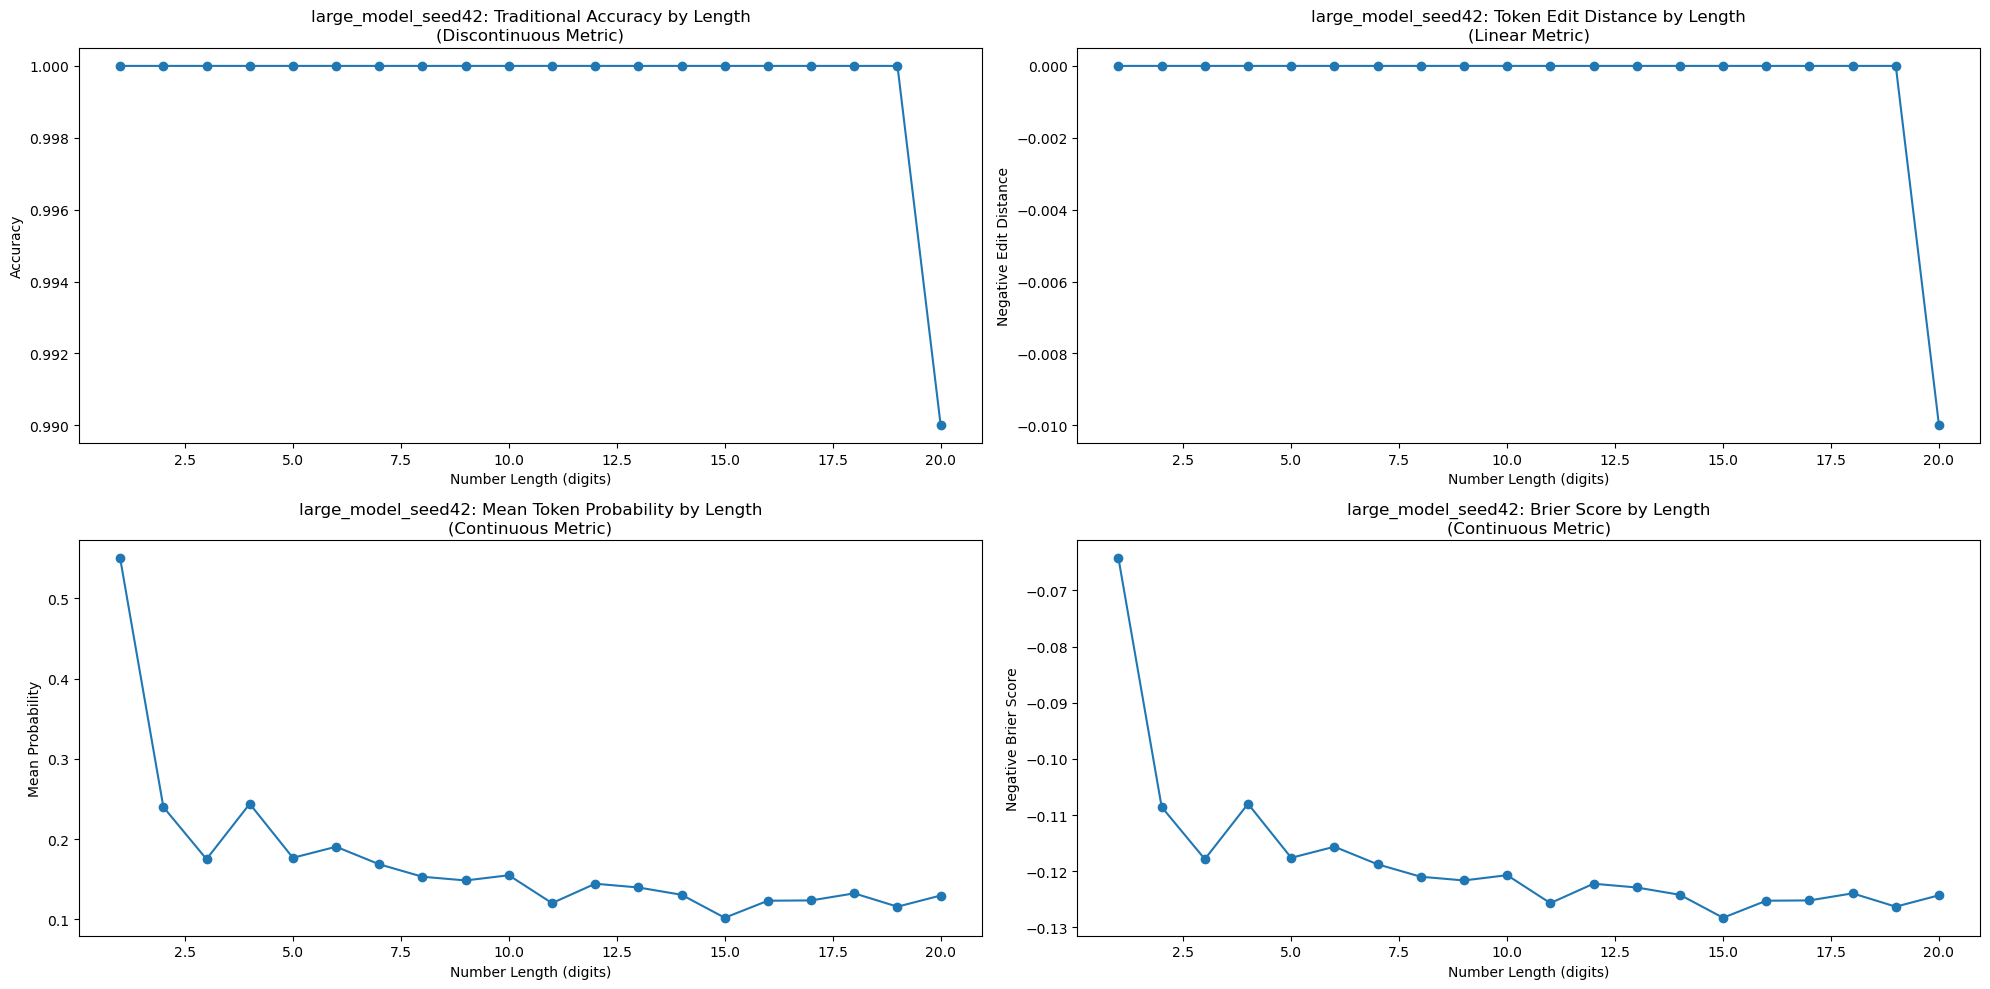


Detailed Statistics for large_model_seed42:
Number of samples: 2000

Performance by metric type:

Discontinuous Metrics:
Overall Accuracy: 0.9995

Linear Metrics:
Mean Edit Distance: 0.0005

Continuous Metrics:
Mean Token Probability: 0.1731
Mean Brier Score: 0.1181

Performance by length ranges:

1-5 digits:
  Accuracy: 1.0000
  Edit Distance: 0.0000
  Token Probability: 0.2771
  Brier Score: 0.1033

6-10 digits:
  Accuracy: 1.0000
  Edit Distance: 0.0000
  Token Probability: 0.1631
  Brier Score: 0.1196

11-15 digits:
  Accuracy: 1.0000
  Edit Distance: 0.0000
  Token Probability: 0.1273
  Brier Score: 0.1247

16-20 digits:
  Accuracy: 0.9980
  Edit Distance: 0.0020
  Token Probability: 0.1249
  Brier Score: 0.1250


In [24]:
# LARGE MODEL COMPREHENSIVE ANALYSIS
print("\n# LARGE MODEL COMPREHENSIVE ANALYSIS")

# Load model and components
model_path = './Weights/large_addition_model.pth'
model, vocab, inv_vocab, max_seq_length = load_model_and_config(model_path)

# Create evaluator with another different random seed
evaluator = ComprehensiveEvaluator(model, vocab, inv_vocab, max_seq_length, random_seed=42)

# Run evaluation
results_df = evaluator.evaluate_model(samples_per_length=100)

# Generate visualizations and save reports
analyze_and_visualize_results(results_df, "large_model_seed42")